In [11]:
from PIL import Image, ImageOps, ImageDraw, ImageFont
import os
import re
import torch
import numpy as np
from collections import defaultdict
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from PIL import Image


In [12]:
def sort_key_func(item):
    match = re.search(r'tile_(\d+)', item)
    return int(match.group(1)) if match else 0


def cut_images(input_dir, output_dir, tile_size=360, stride=36):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    count = 0
    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg'):  # or '.jpg', or whatever your images are
            image_path = os.path.join(input_dir, filename)
            image = Image.open(image_path)
            image_width, image_height = image.size

            for i in range(0, image_height - tile_size + stride, stride):
                for j in range(0, image_width - tile_size + stride, stride):
                    box = (j, i, j + tile_size, i + tile_size)
                    cropped_img = image.crop(box)

                    # Add padding if necessary
                    if cropped_img.size[0] < tile_size or cropped_img.size[1] < tile_size:
                        cropped_img = ImageOps.expand(cropped_img,
                                                      border=((tile_size - cropped_img.size[0]) // 2,
                                                              (tile_size - cropped_img.size[1]) // 2),
                                                      fill='black')

                    count += 1
                    # Save the cropped image
                    cropped_img.save(os.path.join(output_dir, f'{filename[:-4]}_tile_{count}_{i}_{j}.jpg'))


def show_predicted_images(predicted_images_dir, original_images_dir, original_size=(576, 720), noise=True):
    # Prepare an empty dictionary to hold full images
    full_images = {}
    count_images = {}  # count for averaging overlapping areas
    pred_file_list = []

    # Initialize a defaultdict of lists
    grouped_files = defaultdict(list)

    # Group files by prefix
    for filename in os.listdir(predicted_images_dir):
        prefix = re.match(r'(.*_)tile_', filename).group(1)
        grouped_files[prefix].append(filename)

    # Sort each group of files
    for prefix, files in grouped_files.items():
        sorted_files = sorted(files, key=sort_key_func)
        pred_file_list = pred_file_list + sorted_files

    # Iterate through all the images in the predicted_images_dir
    for filename in pred_file_list:
        if filename.endswith('.jpg'):  # or '.jpg', '.png', whatever your predicted images are
            # Extract the original filename from the tile filename
            original_filename = re.match(r'(.*)_tile.*\.jpg', filename).groups()[0]

            # Create a new blank image for this original filename if it doesn't exist
            if original_filename not in full_images:
                full_images[original_filename] = np.zeros(original_size)
                count_images[original_filename] = np.zeros(original_size)

            # Determine the tile's position based on its filename
            _, y, x = map(int, re.match(r'.*_tile_(\d+)_(\d+)_(\d+)\.jpg', filename).groups())

            # Load the predicted image and add its data to the appropriate position in the full image
            image_path = os.path.join(predicted_images_dir, filename)
            predicted_image = Image.open(image_path)
            predicted_data = np.array(predicted_image)

            h = w = 360

            full_images[original_filename][y:y + h, x:x + w] += predicted_data[:h, :w]
            count_images[original_filename][y:y + h, x:x + w] += 1

    # Average overlapping areas and save all the reassembled images
    for original_filename, full_image in full_images.items():
        full_image = full_image / count_images[original_filename]  # Average overlapping areas
        full_image = (full_image > 128).astype('float32') * 255

        # Calculate cloud coverage
        if noise:
            cloud_coverage = np.sum(full_image > 128) / (original_size[0] * original_size[1] - 40000)
        else:
            cloud_coverage = np.mean(full_image > 128)

        # Determine cloudiness
        cloudiness = "cloudy" if cloud_coverage > 0.5 else "clear"

        # Convert full image to PIL Image
        full_image = Image.fromarray(full_image.astype(np.uint8))

        # Load the original image
        original_image = Image.open(os.path.join(original_images_dir, original_filename[5:] + '.jpg'))

        # Define font size
        font_size = 24

        # Create font object
        font = ImageFont.truetype("arial", font_size)

        # Add cloud coverage and cloudiness text to the original image
        draw = ImageDraw.Draw(original_image)
        text = f"Coverage: {cloud_coverage * 100:.1f}% ({cloudiness})"

        # Get the width and height of the text box
        text_width, text_height = draw.textsize(text, font=font)

        # Calculate position for the text
        text_x = original_image.width - text_width - 10
        text_y = 150

        # Add the text to the image
        draw.text((text_x, text_y), text, fill=(0, 0, 0), font=font)

        # Combine original image and full image
        result_image = Image.new('RGB', (original_size[1] * 2, original_size[0]))
        result_image.paste(original_image, (0, 0))
        result_image.paste(full_image, (original_size[1], 0))

        # # Save the result image
        # result_image.save(os.path.join(predicted_images_dir + "_full", f'{original_filename}_full_predicted.jpg'))
        plt.imshow(result_image)
        plt.axis('off')  # Don't show axis
        plt.show()

In [13]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.list_files = os.listdir(self.root_dir)
        self.images = os.listdir(root_dir)  # List all images

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.list_files[idx])
        images = np.array(Image.open(img_path).convert("RGB"))
        origin_images = images
        images = ((images - np.mean(images)) / np.std(images)).astype(np.float32)

        if self.transform:
            images = self.transform(images)
        return images, origin_images, self.images[idx]

In [14]:
# cut images from UCL WebCam dataset to several 300 * 300 small images for further test predict
cut_images("demo/images", "demo/cut_images")

# Define image transformations

image_simple_transforms = transforms.Compose([
    transforms.ToTensor(),
])


# Load test data
test_dataset = TestDataset("demo/cut_images", transform=image_simple_transforms)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('ty_rectify.pth')
model.to(device)
model.eval()

with torch.no_grad():
    for images, origin_images, filenames in test_loader:

        images = images.to(device)
        outputs = model(images)
        pred = torch.argmax(outputs, dim=1).cpu().numpy()

        # Save segmentation output
        for k in range(images.size(0)):
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(origin_images[k].cpu())
            ax[0].set_title('image')
            ax[1].imshow(pred[k])
            ax[1].set_title('predict')
            filename = os.path.splitext(filenames[k])[0]
            plt.savefig(f'demo/output/test_{filename}.png')
            # Save the predicted mask as a separate image
            mask_img = Image.fromarray((pred[k] * 255).astype(np.uint8))
            mask_img.save(f'demo/pred/pred_{filename}.jpg')
            plt.close()


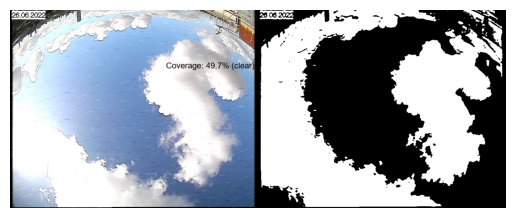

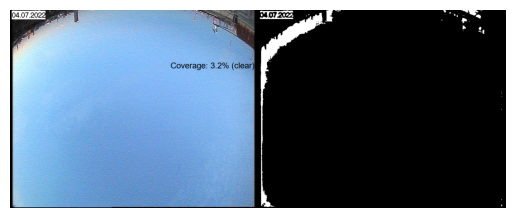

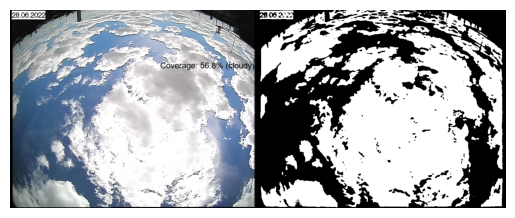

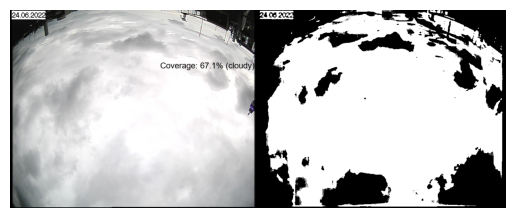

In [15]:
show_predicted_images("demo/pred", "demo/images/",noise = False)